In [1]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
/gdrive


In [2]:
ls

MyDrive/  Shareddrives/


In [3]:
cd/gdrive/MyDrive/Shoes_loafers_and_more/

/gdrive/MyDrive/Shoes_loafers_and_more


In [4]:
ls

boots/  flip_flops/  loafers/  sandals/  sneakers/  soccer_shoes/


In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [6]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [29]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=20
CHANNELS=3

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/Shoes_loafers_and_more",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1463 files belonging to 6 classes.


In [9]:
class_names = dataset.class_names
class_names

['boots', 'flip_flops', 'loafers', 'sandals', 'sneakers', 'soccer_shoes']

In [10]:
len(dataset)

24

In [11]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[238.      242.      243.     ]
  [238.      242.      243.     ]
  [237.      241.      242.     ]
  ...
  [229.      235.      235.     ]
  [228.6875  235.15625 235.     ]
  [227.      236.      235.     ]]

 [[238.      242.      243.     ]
  [238.      242.      243.     ]
  [237.      241.      242.     ]
  ...
  [228.23169 234.23169 234.23169]
  [228.32495 234.7937  234.63745]
  [227.      236.      235.     ]]

 [[238.      242.      243.     ]
  [238.      242.      243.     ]
  [237.      241.      242.     ]
  ...
  [228.      234.      234.     ]
  [227.6875  234.15625 234.     ]
  [226.4436  235.4436  234.4436 ]]

 ...

 [[244.28442 240.45801 234.1438 ]
  [214.16333 211.94727 195.31421]
  [196.198   195.60425 169.2832 ]
  ...
  [214.13208 217.90479 204.33594]
  [214.22656 217.74731 205.30469]
  [212.66406 215.66406 205.42969]]

 [[246.18018 247.44165 244.50879]
  [244.1062  247.84521 241.09204]
  [232.30957 235.81226 226.56982]
  ...
  [209.92

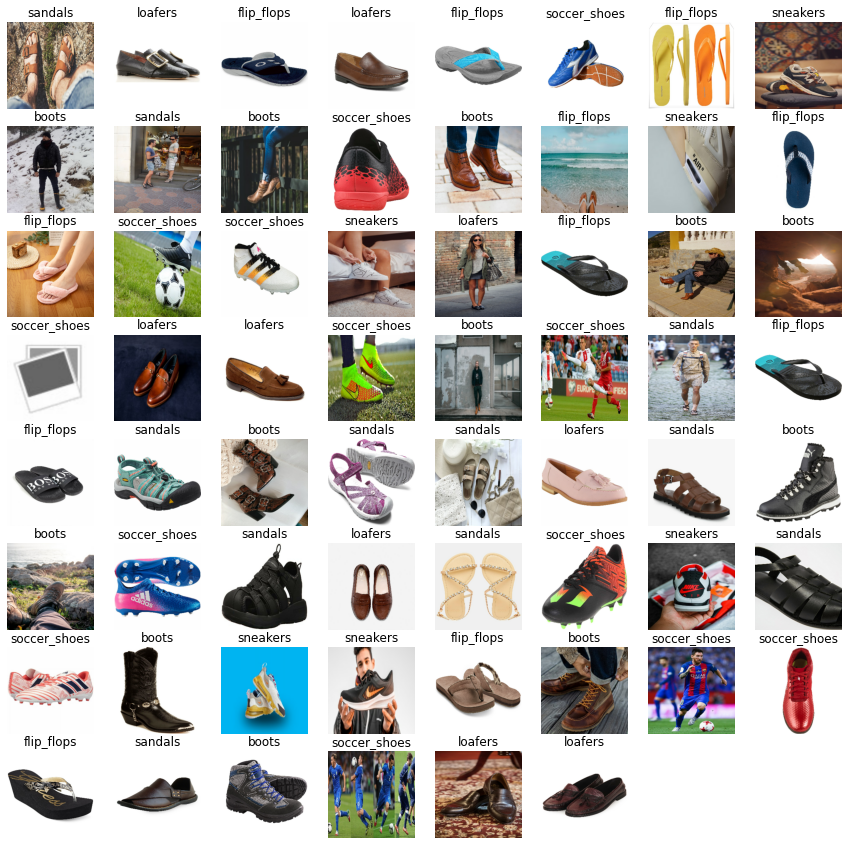

In [12]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [18]:
model.compile(
    optimizer='nadam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (62, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

In [30]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
19/19 [==============================] - 128s 7s/step - loss: 1.1985 - accuracy: 0.5628 - val_loss: 1.1370 - val_accuracy: 0.5455
Epoch 2/20
19/19 [==============================] - 126s 7s/step - loss: 1.1008 - accuracy: 0.5764 - val_loss: 0.9573 - val_accuracy: 0.6566
Epoch 3/20
19/19 [==============================] - 130s 7s/step - loss: 0.9611 - accuracy: 0.6477 - val_loss: 0.9774 - val_accuracy: 0.5960
Epoch 4/20
19/19 [==============================] - 127s 7s/step - loss: 0.8281 - accuracy: 0.6868 - val_loss: 0.8266 - val_accuracy: 0.7071
Epoch 5/20
19/19 [==============================] - 126s 7s/step - loss: 0.6749 - accuracy: 0.7496 - val_loss: 0.7175 - val_accuracy: 0.7172
Epoch 6/20
19/19 [==============================] - 127s 7s/step - loss: 0.5990 - accuracy: 0.7869 - val_loss: 0.7125 - val_accuracy: 0.7980
Epoch 7/20
19/19 [==============================] - 131s 7s/step - loss: 0.5040 - accuracy: 0.8166 - val_loss: 0.9339 - val_accuracy: 0.7677
Epoch 8/20
19

In [31]:
model.evaluate(test_ds)

3/3 [==============================] - 6s 2s/step - loss: 1.0687 - accuracy: 0.8817


[1.068716287612915, 0.8817204236984253]

In [32]:
acc = history.history['accuracy']
loss = history.history['loss']

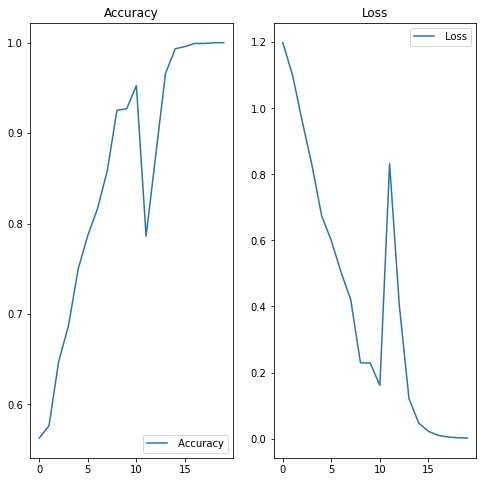

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

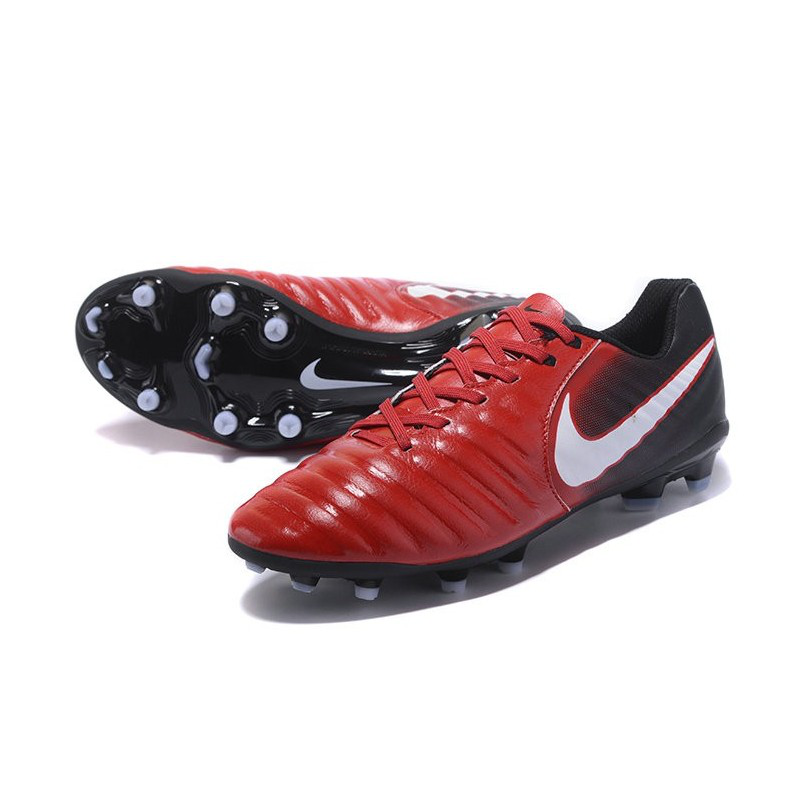

In [34]:
image_path = "/gdrive/My Drive/image249.jpeg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [35]:
pred = model.predict(scaled_img)

In [36]:
output = class_names[np.argmax(pred)]

In [37]:
output

'soccer_shoes'

In [38]:
model.save("Shoes_loafers_and_more.h5")